In [673]:
# Read Data
import numpy as np
import pandas as pd
%run ../src/campus_src.py


In [674]:
df = pd.read_csv("../data/processed/campus_processed.csv")
df = df.set_index("DateTime")

## Create Dataset

In [675]:
# 假設 df_encoded 是你的 DataFrame，且已經按時間順序排序
#n_steps = 8  # 例如，使用t以及前面5步作為特徵
#論文設定成3
n_steps = 3
X, y = create_dataset(df.to_numpy(), n_steps)

print(y)
print(X.shape)
print(y.shape)

[222.326142 220.546435 205.955438 ...  73.581269 156.333926 222.44631 ]
(4316, 3, 35)
(4316,)


## Split

In [651]:
X_train, X_validation, X_test, y_train, y_validation, y_test = split_dataset(X, y, train_ratio=0.75, validation_ratio=0.15)

## Attack

In [676]:
def attack_all_add_pct(X, step_idx=7, feat_idx=1, pct=0.05):
    """
    对 X 中所有样本，在指定的 step_idx 和 feat_idx 位置，
    将原值增加 pct * 原值（即乘以 1+pct）。

    参数：
        X (np.ndarray): 待“攻击”的三维数组，shape=(n_samples, n_steps, n_features)
        step_idx (int): 时间步的索引，比如第8步就传 7
        feat_idx (int): 特征的索引，比如第2个特征就传 1
        pct (float): 增加比例，默认 0.05（5%）

    返回：
        np.ndarray: 攻击后的数组副本
    """
    X_attacked = X.copy()
    X_attacked[:, step_idx, feat_idx] *= (1 + pct)
    return X_attacked

#X_test_attacked = attack_all_add_pct(X_test, step_idx=7, feat_idx=1, pct=0.2)
#X_test_attacked = attack_all_add_pct(X_test_attacked, step_idx=7, feat_idx=2, pct=0.2)

#X_test = X_test_attacked.copy()

## Scaler

In [677]:
X_train, X_validation, X_test = scaling(X_train, X_validation, X_test, 3)

## =====================

## Model

In [678]:
"""
for i in range(len(X_train)): #每個X_train
  # 应用噪声
  X_train[i] = add_noise(X_train[i], noise_level=0.05)
"""

'\nfor i in range(len(X_train)): #每個X_train\n  # 应用噪声\n  X_train[i] = add_noise(X_train[i], noise_level=0.05)\n'

In [679]:
import numpy as np
X_train = np.array(X_train, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)
X_validation = np.array(X_validation, dtype=np.float32)
y_validation = np.array(y_validation, dtype=np.float32)
X_test = np.array(X_test, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)

In [680]:
# 构建模型
look_back = n_steps;
n_features = X_train.shape[2]
#model = build_model_TCN(look_back, n_features)

batch_size = 128

"""举几个常见的 α 值特点：

α=1（Beta(1,1)）：均匀分布，λ 在 [0,1] 上等概率——可能落到 0.1、0.9、0.5，都是一样的概率。

α=2 或 3（Beta(2,2) / Beta(3,3)）：比均匀分布更偏向中间，抽到 0.5 左右的几率会更高，但也还会有比较大的概率落到 0.2 或 0.8。

α=5 或 10（Beta(5,5) / Beta(10,10)）：分布就非常集中在 0.5 附近，几乎不会抽出 0.1 或 0.9，大部分 λ 都在 0.4–0.6（甚至 0.45–0.55）之间。
"""

model = WrapperTCNWithFGSMMixup(
    look_back=look_back,
    n_features=n_features,
    epsilon=0.5,   # FGSM 扰动幅度
    alpha=0.3,     # Beta(0.3,0.3)，Mixup 的形状参数
    step_idx=look_back-1, # 如果要“定点打扰”，可以设置一个整数
    feat_idx=[1, 2]  # 如果要“定点打扰”，可以设置一个整数
)
#  忘記 mixup feature 2 了！！ (6/4)

# 2) compile：只要给一个 optimizer + loss_fn，与 build_model_TCN 中的保持一致即可
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=lambda y_true, y_pred: tf.sqrt(
        tf.reduce_mean(tf.square(y_true - y_pred))
    )  # RMSE
)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=batch_size,
    validation_data=(X_validation, y_validation),
    callbacks=[early_stopping]
)


# 5) 评估/预测
test_loss = model.evaluate(X_test, y_test)
y_pred    = model.predict(X_test)


/opt/anaconda3/envs/tf310/lib/python3.10/site-packages/tcn/tcn.py:268: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


Model: "sequential_59"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ tcn_68 (TCN)                    │ (None, 64)             │        97,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_177 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_178 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_59 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_179 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 103,937 (406.00 KB)

 Trainable params: 103,937 (406.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - loss: 102.3848 - val_loss: 43.9366
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 47.0673 - val_loss: 20.9845
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 27.6628 - val_loss: 15.7986
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 21.6214 - val_loss: 13.6085
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 20.6952 - val_loss: 13.9365
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 18.5365 - val_loss: 13.3538
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 17.9838 - val_loss: 14.5294
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 19.5592 - val_loss: 13.2073
Epoch 9/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 18.5452 - val_loss: 12.9596
Epoch 10/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 16.7331 - val_loss: 14.4562
Epoch 11/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 17.3645 - val_loss: 14.1265
Epoch 12/100
26/26 ━━━━━━━━━━

In [681]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# original models.
normal_model = build_model_TCN(look_back, n_features)
history = normal_model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=128,
    validation_data=(X_validation, y_validation),
    callbacks=[early_stopping]  # 加入早期停止回調函數
)

Model: "sequential_60"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ tcn_69 (TCN)                    │ (None, 64)             │        97,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_180 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_181 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_60 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_182 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 103,937 (406.00 KB)

 Trainable params: 103,937 (406.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 97.8133 - val_loss: 35.4210
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 40.5038 - val_loss: 16.9054
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 19.3839 - val_loss: 12.4015
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 16.2502 - val_loss: 13.7399
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 16.5231 - val_loss: 13.5017
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 15.2435 - val_loss: 12.3214
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 14.5383 - val_loss: 12.8312
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 15.3182 - val_loss: 12.0961
Epoch 9/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 14.8380 - val_loss: 12.7079
Epoch 10/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 13.8042 - val_loss: 12.4527
Epoch 11/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 14.4912 - val_loss: 12.9656
Epoch 12/100
26/26 ━━━━━━━━━━━

In [699]:
# “只要 step_idx, feat_idx 就一定给那点加 ε” ？
# 不完全对，还要看该点的 grad_sign 是否为 1。如果梯度是 0（也就是模型认为改那个位置没法增大损失），grad_sign 会是 0，于是你在这段代码里 并不会把 epsilon 加过去。

# “会不会有某些点加超过 20%，某些点不加？”

# “加超过 20%”：不会。因为你只在 grad_sign=1 的地方加上了一个“恒定”的 epsilon（这里 epsilon=0.2），绝对不可能加超过 0.2。

# “某些点不加”：会。那是因为如果 grad_sign 在 (step_idx, feat_idx) 位置为 0，那么 grad_sign * mask 就是 0，自然不加任何东西。也就是说，有的样本在那个位置梯度是负或 0，就不会被改动。

#定点扰动（您原始的需求）：
# adv_x = fgsm_inject_one_pos(
#     model, 
#     X, 
#     y, 
#     epsilon=0.1,
#     step_idx=7, 
#     feat_idx=1
# )
# #全局扰动（与原始FGSM相同）：
# adv_x = fgsm_inject_one_pos(
#     model, 
#     X, 
#     y, 
#     epsilon=0.1
#     # 不指定step_idx和feat_idx
# )

#想让它都预测成原来的两倍，就写 target_labels = y_test * 2.0
#定向攻击：

# adv_x = fgsm_inject_one_pos(
#     model, 
#     X, 
#     target_y,  # 传入目标标签
#     epsilon=0.1,
#     targeted=True
# )
 
# targeted 支持你选择是做普通的 untargeted 式白帽攻击（最大化正确标签损失），还是做针对某个目标标签的 targeted 攻击（最小化目标标签损失）。


# —— 使用示例 —— #
epsilon = 0.2
X_test_adv = None
# 时间维度上，论文中的 FGSM 只针对 当前时刻 𝑡 的快照进行扰动，不会“连带”把 𝑡 − 1 , 𝑡 − 2 , … t−1,t−2,… 一并改动；
#定點干擾

#被mixup模型干擾
X_test_adv_mixup = fgsm_inject_one_pos(model, X_test, y_test, epsilon, step_idx=n_steps-1, feat_idx=[1, 2])
#被普通模型干擾
X_test_adv_normal = fgsm_inject_one_pos(normal_model, X_test, y_test, epsilon, step_idx=n_steps-1, feat_idx=[1, 2])
#全局干擾
#X_test_adv = fgsm_inject_one_pos(normal_model, X_test, y_test, epsilon)

# preds_clean_normal = normal_model.predict(X_test)
# preds_clean_mixup = model.predict(X_test)

#preds_adv_mixup   = model.predict(X_test_adv)    # 一定要传 X_test_adv
#preds_adv_normal   = normal_model.predict(X_test_adv_normal)    # 一定要传 X_test_adv

# print("max abs diff of normal:", np.max(np.abs(preds_adv_normal - preds_clean_normal)))
# print("max abs diff of mixup:", np.max(np.abs(preds_adv_mixup - preds_clean_mixup)))

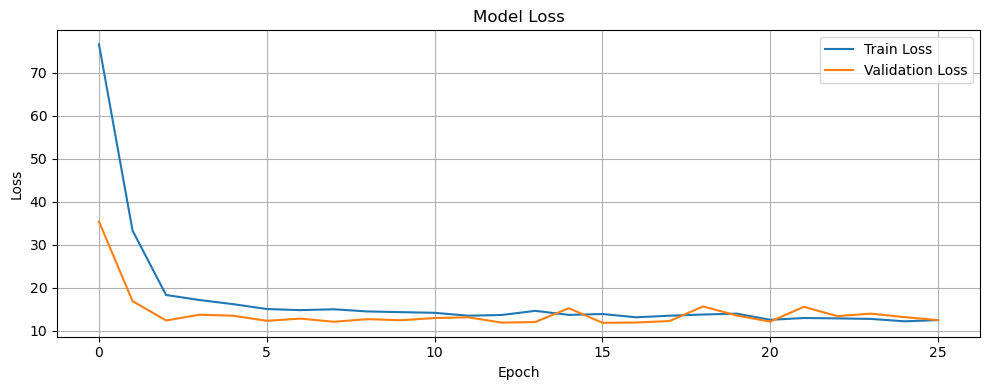

In [688]:
plot_loss(history)

Testing Length: 432
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


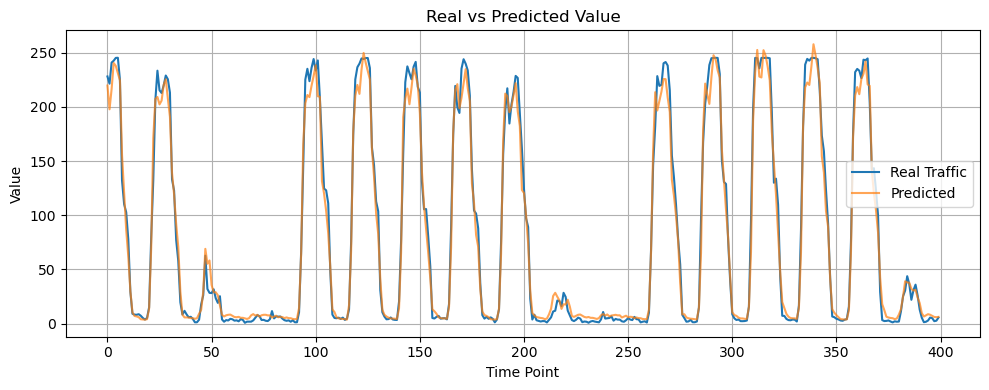

In [700]:
plot_predictions(model, X_test_adv_mixup, y_test, start=0, end=400)

Testing Length: 432
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


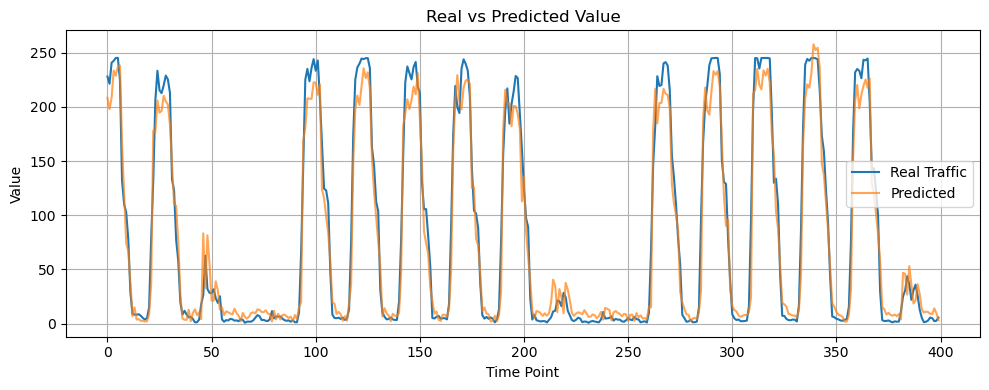

In [701]:
plot_predictions(normal_model, X_test_adv_normal, y_test, start=0, end=400)

In [703]:
print("Mixup Method")
print("未擾動")
predicted = model.predict(X_test).reshape(-1, 1)
result_normal = evaluate_regression(y_test, predicted)
print("擾動")
predicted = model.predict(X_test_adv_mixup).reshape(-1, 1)
result_attacked = evaluate_regression(y_test, predicted)

Mixup Method
未擾動
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Mean Absolute Error: 7.3278632164001465
Mean Squared Error: 115.58004760742188
Root Mean Squared Error: 10.750816136806632
R^2 Score: 0.9867243766784668
Mean Absolute Percentage Error: 0.6197682023048401
擾動
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Mean Absolute Error: 7.524553298950195
Mean Squared Error: 119.60748291015625
Root Mean Squared Error: 10.936520603471482
R^2 Score: 0.986261785030365
Mean Absolute Percentage Error: 0.6370587944984436


In [702]:
print("Normal Method")
print("未擾動")
predicted = normal_model.predict(X_test).reshape(-1, 1)
result_attacked = evaluate_regression(y_test, predicted)
print("擾動")
predicted = normal_model.predict(X_test_adv_normal).reshape(-1, 1)
result_attacked = evaluate_regression(y_test, predicted)

Normal Method
未擾動
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Mean Absolute Error: 7.223519802093506
Mean Squared Error: 114.47587585449219
Root Mean Squared Error: 10.699339972843754
R^2 Score: 0.9868512153625488
Mean Absolute Percentage Error: 0.5110260844230652
擾動
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Mean Absolute Error: 13.592131614685059
Mean Squared Error: 317.2801513671875
Root Mean Squared Error: 17.81235951150738
R^2 Score: 0.9635568857192993
Mean Absolute Percentage Error: 1.1190434694290161


In [330]:
# Create a DataFrame to compare the values
df_compare = pd.DataFrame({
    'Metric': list(result_normal.keys()),
    'Normal': list(result_normal.values()),
    'Attacked': list(result_attacked.values())
})

# Calculate absolute and percentage differences
df_compare['Absolute Difference'] = df_compare['Attacked'] - df_compare['Normal']
df_compare['% Difference'] = ((df_compare['Absolute Difference'] / df_compare['Normal']) * 100)
df_compare

,Metric,Normal,Attacked,Absolute Difference,% Difference
0,MAE,6.848458,9.084687,2.236229,32.653036
1,MSE,110.009964,157.027420,47.017456,42.739270
2,RMSE,10.488563,12.531058,2.042495,19.473541
3,R2,0.987364,0.981964,-0.005400,-0.546959
4,MAPE,0.382416,0.767118,0.384701,100.597517


In [ ]:
import os
import pandas as pd
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from math import sqrt

# 定義一個函式，強制從 _1 開始依序編號檔名
def get_unique_filename(filename):
    """
    不論檔案是否存在，皆從 _1 開始附加到檔名上，
    若有同樣編號的檔案存在，則依序累加編號，直到找到尚不存在的檔名。
    """
    base, ext = os.path.splitext(filename)
    i = 1
    unique_filename = f"{base}_{i}{ext}"
    while os.path.exists(unique_filename):
        i += 1
        unique_filename = f"{base}_{i}{ext}"
    return unique_filename

# ------------------------
# 對測試集進行預測及計算指標
# ------------------------

# 進行測試集預測並轉換成一維陣列
predicted_test = model.predict(X_test).reshape(-1, 1)

# 計算各項回歸評估指標
mse = mean_squared_error(y_test, predicted_test)
mae = mean_absolute_error(y_test, predicted_test)
rmse = sqrt(mse)
r2 = r2_score(y_test, predicted_test)
mape = mean_absolute_percentage_error(y_test, predicted_test)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R^2 Score: {r2}')
print(f'MAPE: {mape}')

# 將測試集真值與預測結果合併成 DataFrame
test_results = pd.DataFrame({
    'True': y_test.flatten(),
    'Predicted': predicted_test.flatten()
})

# 取得唯一檔名並儲存測試集結果成 CSV 檔案
test_csv_filename = get_unique_filename('test_predictions.csv')
test_results.to_csv(test_csv_filename, index=False)
print(f"測試集結果儲存到檔案: {test_csv_filename}")

# ------------------------
# 對訓練集進行預測並儲存結果
# ------------------------

# 預測訓練集資料
predicted_train = model.predict(X_train).reshape(-1, 1)

# 將訓練集真值與預測結果合併成 DataFrame
train_results = pd.DataFrame({
    'True': y_train.flatten(),
    'Predicted': predicted_train.flatten()
})

# 取得唯一檔名並儲存訓練集結果成 CSV 檔案
train_csv_filename = get_unique_filename('train_predictions.csv')
train_results.to_csv(train_csv_filename, index=False)
print(f"訓練集結果儲存到檔案: {train_csv_filename}")

# 結果分析

## 每小時誤差

In [ ]:
for index, row in df_extraction.iterrows():
  for i in range(len(y_test)):
    if (row["value_avg"]/1000000) == y_test[i]:
      df_extraction.loc[index, "predicted"] = predicted[i][0]

In [ ]:
df_extraction_hour = df_extraction.dropna()

In [ ]:
df_extraction_hour["value_avg"] = df_extraction_hour["value_avg"] / 1000000

In [ ]:
df_extraction_hour

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

data = df_extraction_hour.copy()

hours = data.groupby(data["hour"])

mae = hours.apply(lambda x: np.mean(np.abs(x['value_avg'] - x['predicted'])))
rmse = hours.apply(lambda x: np.sqrt(np.mean((x['value_avg'] - x['predicted'])**2)))
mape = hours.apply(lambda x: np.mean(np.abs((x['value_avg'] - x['predicted']) / x['value_avg'])) * 100)

print('MAE for each hour:')
print(mae)
print('\nRMSE for each hour:')
print(rmse)
print('\nMAPE for each hour:')
print(mape)

hours = range(24)
plt.figure(figsize=(12, 6))
plt.plot(hours, mae, label='MAE')
plt.plot(hours, rmse, label='RMSE')
plt.plot(hours, mape, label='MAPE')
plt.xlabel('Hour')
plt.ylabel('Error')
plt.title('MAE, RMSE and MAPE for each hour')
plt.xticks(hours)
plt.legend()
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

data = df_extraction_hour.copy()

hours = data.groupby(data["weekday"])

mae = hours.apply(lambda x: np.mean(np.abs(x['value_avg'] - x['predicted'])))
rmse = hours.apply(lambda x: np.sqrt(np.mean((x['value_avg'] - x['predicted'])**2)))
mape = hours.apply(lambda x: np.mean(np.abs((x['value_avg'] - x['predicted']) / x['value_avg'])) * 100)

print('MAE for each hour:')
print(mae)
print('\nRMSE for each hour:')
print(rmse)
print('\nMAPE for each hour:')
print(mape)

hours = range(7)
plt.figure(figsize=(12, 6))
plt.plot(hours, mae, label='MAE')
plt.plot(hours, rmse, label='RMSE')
plt.plot(hours, mape, label='MAPE')
plt.xlabel('Hour')
plt.ylabel('Error')
plt.title('MAE, RMSE and MAPE for each weekday')
plt.xticks(hours)
plt.legend()
plt.show()